In [104]:
#Importing relevant libraries and packages

import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import datetime as dt
from datetime import time
from datetime import timedelta
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 
from sklearn.metrics import precision_recall_curve, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.decomposition import PCA

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [105]:
#Importing train and test dataset

transactions_train_df = pd.read_csv("/content/drive/MyDrive/Code Girls First/Project/Data/Simulated Fraud/fraudTrain.csv", parse_dates=["trans_date_trans_time"])
transactions_test_df = pd.read_csv("/content/drive/MyDrive/Code Girls First/Project/Data/Simulated Fraud/fraudTest.csv", parse_dates=["trans_date_trans_time"])

In [106]:
#Appending both datasets

df = transactions_train_df.append(transactions_test_df, ignore_index=True)

In [107]:
#Verifying the columns available

df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [108]:
#Displaying dataset

df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [109]:
#Verifying the datatypes in the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Unnamed: 0             int64         
 1   trans_date_trans_time  datetime64[ns]
 2   cc_num                 int64         
 3   merchant               object        
 4   category               object        
 5   amt                    float64       
 6   first                  object        
 7   last                   object        
 8   gender                 object        
 9   street                 object        
 10  city                   object        
 11  state                  object        
 12  zip                    int64         
 13  lat                    float64       
 14  long                   float64       
 15  city_pop               int64         
 16  job                    object        
 17  dob                    object        
 18  trans_num             

In [110]:
#Verifying the existence of null values 

df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [111]:
#Creating new variables from existing data

##1 - Business hours / Non business hours

### Creating a column for business_hour with zero as default
df["business_hour"] = int(0)

###Considering business hours between 8:00-19:00
start = dt.datetime.strptime("08:00:00", "%H:%M:%S").time()
end = dt.datetime.strptime("19:00:00", "%H:%M:%S").time()

###Defining a mask for the query that catches data within the defined range
businessHour_mask = df["trans_date_trans_time"].dt.time.between(start, end)

###Setting numbers that fit into encoding to 1
df["business_hour"][businessHour_mask] = 1

##2 - Weekdays / Weekends

### Defining weekdays bin, being weekdays from Monday to Friday (0-4) and weekends Saturday and Sunday (5-6). Weekdays will be labelled as 1 and weekends as 0
weekDay_list = [0,1,2,3,4]
weekEnd_list = [5,6]

###Creating a new column is_weekday

df["is_weekday"] = int(0)

###Applying the weekday rule into the dataset
df["is_weekday"][df["trans_date_trans_time"].dt.weekday.isin(weekDay_list)] = 1
df["is_weekday"][df["trans_date_trans_time"].dt.weekday.isin(weekEnd_list)] = 0


##3 - Months

###Extracting the month
df["month"] = df["trans_date_trans_time"].dt.strftime("%m")

##4 - Time since las transaction in the same card

###Creating a function to parse time difference between rows

def time_difference(df):
  df["time_diff"] = df["unix_time"] - df["unix_time"].shift()
  return df

###Applying the function to dataset grouped by creditcard number

df = df.groupby("cc_num").apply(time_difference)

###Replacing NaN with zeroes
df['time_diff'] = df['time_diff'].fillna(0)

##5 - Frequency of transacations in the same card in time intervals of 1 and 7 days

###Creating functions to extract frequency of transactions in the time intervals
def last_day(df):
    temp = pd.Series(df.index, index = df["trans_date_trans_time"], name='count_1_day').sort_index()
    count_1_day = temp.rolling('1d').count() - 1
    count_1_day.index = temp.values
    df['count_1_day'] = count_1_day.reindex(df.index)
    return df

def last_week(df):
    temp = pd.Series(df.index, index = df["trans_date_trans_time"], name='count_7_days').sort_index()
    count_7_days = temp.rolling('7d').count() - 1
    count_7_days.index = temp.values
    df['count_7_days'] = count_7_days.reindex(df.index)
    return df

###Applying functions to dataframe

df = df.groupby('cc_num').apply(last_day)
df = df.groupby('cc_num').apply(last_week)

##6 - Numeric age

###Transforming date of birth into numeric age
yearCharacters = 4
currentYear = int(dt.datetime.now().strftime("%Y"))

df["age"] = currentYear - df["dob"].str[:yearCharacters].astype(int)

###Dropping the original column "dob"
df.drop(['dob'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [112]:
#Removing irrelevant variables

irrelevantVar_list = ["first",
                      "last", 
                      "street", 
                      "zip",
                      "lat",
                      "job",
                      "long",
                      "cc_num", 
                      "unix_time",
                      "trans_date_trans_time",
                      "trans_num", 
                      "merch_lat",
                      "merch_long"]

df.drop(irrelevantVar_list, axis=1, inplace=True)

In [113]:
#Encoding variables

##1 - Target Encoding merchant categories

###Getting the means for each category
merchantMeans_dict = df.groupby('category')['is_fraud'].mean().to_dict()

###Replacing the categorical labels with the means
df['category'] = df['category'].map(merchantMeans_dict)

##2 - Target Encoding states

###Getting the means for each state
statetMeans_dict = df.groupby('state')['is_fraud'].mean().to_dict()

###Replacing the categorical labels with the means
df['state'] = df['state'].map(statetMeans_dict)


##3 - Target Encoding cities

cityMeans_dict = df.groupby('city')['is_fraud'].mean().to_dict()


df["city"] =  df["city"].map(cityMeans_dict)

##4 - Target Encoding the merchant

merchantMeans_dict = df.groupby("merchant")['is_fraud'].mean().to_dict()

df["merchant"] = df['merchant'].map(merchantMeans_dict)

##5 - Label encoding Male / Female

###Defining 1 as male and 2 as female and replacing values
df["gender"].replace('F', 0, inplace=True)
df["gender"].replace('M', 1, inplace=True)

In [114]:
#Separating the data into train and test

##1 - Separating X and y
X = df.drop(["is_fraud", "Unnamed: 0"], axis=1)
y = df['is_fraud']

##2 - Splitting dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, stratify=y, random_state=100)

##3 - Inspecting train and test datasets
print ('Train Dataset : ', X_train.shape)
print ('Test Dataset : ', X_test.shape)

Train Dataset :  (1296675, 14)
Test Dataset :  (555719, 14)


In [115]:
#Fitting the model into the data

clf_en = DecisionTreeClassifier(random_state=0)
clf_en.fit(X_train, y_train)

#Predicting fraudulent transactions 

y_pred = clf_en.predict(X_test)

In [116]:
#Verifying the results

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9969121084576917
Precision: 0.6965655218406135
Recall: 0.7215889464594127


In [118]:
#Plotting a confusion matrix to visualize the performance. 
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[551914,    910],
       [   806,   2089]])

Text(0.5, 257.44, 'Predicted label')

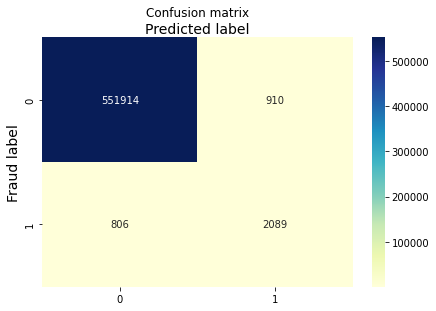

In [119]:
# Showing confusion matrix as a heatmap

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Fraud label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)